In [ ]:
import numpy as np 
import pandas as pd 
import os
import gc
from joblib import load, dump
import joblib

In [2]:
# Paths
BASE_DIR = '../'
#PATH_TO_PREDICT = os.path.join(BASE_DIR, "Dataset/predecir.parquet")
#PATH_TO_PREDICT = os.path.join(BASE_DIR, "Dataset/predecir_producto.parquet")
PATH_TO_PREDICT = os.path.join(BASE_DIR, "Dataset/1_c_producto_predecir.parquet")
#PATH_TO_ESCALA = os.path.join(BASE_DIR, "Dataset/factores_escala_por_producto.csv")
#PATH_TO_PREDICT = os.path.join(BASE_DIR, "Dataset/predecir_producto_201910.parquet")
PATH_TO_MODELS = os.path.join(BASE_DIR, "LGBM/models")
#PATH_TO_MODELS_BAJO_VOL = os.path.join(BASE_DIR, "LGBM/models/bajos")
PATH_TO_TEMP_FILES = os.path.join(BASE_DIR, "LGBM/optuna/optuna_temp_artifacts")
PATH_TO_OPTUNA_ARTIFACTS = os.path.join(BASE_DIR, "LGBM/optuna/optuna_artifacts")

SEED = 42

In [ ]:
# 1️⃣ definí la clase igual que antes
class StdDivisorScaler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        X = np.asarray(X)
        self.stds_ = np.nanstd(X, axis=0)
        self.stds_[self.stds_ == 0] = 1.0
        return self

    def transform(self, X):
        X = np.asarray(X)
        X_out = X.copy()
        for col_idx in range(X_out.shape[1]):
            col_data = X_out[:, col_idx]
            mask = ~np.isnan(col_data)
            col_data[mask] = col_data[mask] / self.stds_[col_idx]
            X_out[:, col_idx] = col_data
        return X_out

    def inverse_transform(self, X):
        X = np.asarray(X)
        X_out = X.copy()
        for col_idx in range(X_out.shape[1]):
            col_data = X_out[:, col_idx]
            mask = ~np.isnan(col_data)
            col_data[mask] = col_data[mask] * self.stds_[col_idx]
            X_out[:, col_idx] = col_data
        return X_out

In [3]:
# Datos Tabulares
dataset = pd.read_parquet(PATH_TO_PREDICT)
productos_a_predecir= pd.read_csv(os.path.join(BASE_DIR, "Dataset/product_id_apredecir201912.txt"), sep='\t')

In [4]:
dataset = dataset.loc[dataset['periodo'] == 201912]

In [5]:
del dataset['ultima_tn']

In [ ]:
# 🔷 Cargar lo que guardaste en train
(preprocessor, cols_to_scale, cols_to_keep, dtypes_originales, dtypes_escala) = joblib.load(
    'escalador_completo_stddiv.joblib'
)

# 🔷 Transformar todo test
X_test_transformed = preprocessor.transform(dataset)

# El resultado es un numpy.ndarray con las columnas en el orden:
# primero cols_to_scale (escaladas) y después cols_to_keep (passthrough)
# reconstruimos en DataFrame
all_cols_order = cols_to_scale + cols_to_keep
dataset = pd.DataFrame(X_test_transformed, columns=all_cols_order, index=dataset.index)

# 🔷 Restaurar dtypes en cols_to_scale y cols_to_keep

# Para cols_to_scale: asegurarse de que las originalmente int sigan siendo float (por los NaN)
for col in cols_to_scale:
    if pd.api.types.is_integer_dtype(dtypes_escala[col]):
        dataset[col] = pd.to_numeric(dataset[col], errors='coerce').astype(float)
    elif pd.api.types.is_float_dtype(dtypes_escala[col]):
        dataset[col] = pd.to_numeric(dataset[col], errors='coerce').astype(float)

# Para cols_to_keep: devolver exactamente al dtype original
for col in cols_to_keep:
    # primero asegurarse que esté en str si es necesario
    if pd.api.types.is_categorical_dtype(dtypes_originales[col]) or pd.api.types.is_object_dtype(dtypes_originales[col]):
        dataset[col] = dataset[col].astype(str)
    # ahora castear al tipo original
    dataset[col] = dataset[col].astype(dtypes_originales[col])

print("\n✅ DataFrame final TEST con std divisor scaler:\n")
print(dataset.dtypes)
print(dataset.head())

# 🔷 liberar memoria
del X_test_transformed
gc.collect()

In [6]:
dataset.head()

,periodo,product_id,producto_total_tn,avg_tn,std_tn,clientes_distintos,cust_request_qty,cust_request_tn,inicio_vida_p,fin_vida_p,...,n_meses_hist,tn_pred_auto_delta_a_tn,ratio_tn_pred_auto_delta_a_tn,ratio_tn_pred_a_tn,cluster_2,cluster_3,cluster_10,cluster_50,cluster_100,cluster_500
1,201912,20001,1505.0,2.519531,15.929688,597,407,1650.0,201701,201912,...,34.0,-41.250000,-0.027420,0.972656,0,2,2,5,5,2
3,201912,20002,1087.0,1.821289,17.156250,597,217,1092.0,201701,201912,...,34.0,106.687500,0.098145,1.098633,0,2,2,5,5,2
5,201912,20003,892.5,1.495117,8.257812,597,314,970.0,201701,201912,...,34.0,-16.015625,-0.017944,0.981934,0,0,1,33,67,271
7,201912,20004,638.0,1.068359,4.445312,597,313,678.5,201701,201912,...,34.0,106.000000,0.166138,1.166016,0,2,2,5,5,2
9,201912,20005,593.0,0.993652,5.593750,597,269,630.5,201701,201912,...,34.0,114.437500,0.192993,1.193359,0,0,1,30,61,495


In [7]:
dataset.shape

(927, 310)

In [8]:
#unir en un solo dataset
dataset = (
    dataset
    .merge(productos_a_predecir, on='product_id', how='inner')
)

In [9]:
#del dataset['volumen_alto']

In [10]:
dataset.shape

(780, 310)

In [11]:
def tipos_correctos(df, verbose=True):
    start_mem = df.memory_usage(deep=True).sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype

        #   - Datetime
        # 1) Datetime → int64 (ns) → float32
        if pd.api.types.is_datetime64_any_dtype(col_type):
            # view() extrae los nanosegundos desde epoch
            df[col] = df[col].view('int64').astype('float32')
            continue


        # Solo nos ocupamos de numéricos
        if not pd.api.types.is_numeric_dtype(col_type):
            if not pd.api.types.is_categorical_dtype(col_type):
                df[col] = df[col].astype('category')
            continue

        c_min, c_max = df[col].min(), df[col].max()
        has_na = df[col].isnull().any()

        # --- ENTEROS ---
        if pd.api.types.is_integer_dtype(col_type):
            # 1) Sin nulos → numpy ints
            if not has_na:
                if c_min >= np.iinfo(np.int8).min  and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)


        # --- FLOTANTES ---
        else:
            df[col] = df[col].astype(np.float32)

    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose:
        print(f'Uso de memoria inicial del DataFrame: {start_mem:.2f} MB')
        print(f'Uso de memoria final del DataFrame:   {end_mem:.2f} MB')
        print(f'Memoria reducida en un {(100*(start_mem-end_mem)/start_mem):.2f}%')
    return df

In [12]:
dataset = tipos_correctos(dataset)

Uso de memoria inicial del DataFrame: 0.54 MB
Uso de memoria final del DataFrame:   0.89 MB
Memoria reducida en un -65.79%


C:\Users\diana\AppData\Local\Temp\ipykernel_14080\57235330.py:17: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(col_type):
C:\Users\diana\AppData\Local\Temp\ipykernel_14080\57235330.py:17: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(col_type):
C:\Users\diana\AppData\Local\Temp\ipykernel_14080\57235330.py:17: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(col_type):
C:\Users\diana\AppData\Local\Temp\ipykernel_14080\57235330.py:11: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtyp

In [13]:
pred=dataset.copy()

In [14]:
pred.head(20)

,periodo,product_id,producto_total_tn,avg_tn,std_tn,clientes_distintos,cust_request_qty,cust_request_tn,inicio_vida_p,fin_vida_p,...,n_meses_hist,tn_pred_auto_delta_a_tn,ratio_tn_pred_auto_delta_a_tn,ratio_tn_pred_a_tn,cluster_2,cluster_3,cluster_10,cluster_50,cluster_100,cluster_500
0,201912,20001,1505.000,2.519531,15.929688,597,407,1650.000,201701,201912,...,34.0,-41.250000,-0.027420,0.972656,0,2,2,5,5,2
1,201912,20002,1087.000,1.821289,17.156250,597,217,1092.000,201701,201912,...,34.0,106.687500,0.098145,1.098633,0,2,2,5,5,2
2,201912,20003,892.500,1.495117,8.257812,597,314,970.000,201701,201912,...,34.0,-16.015625,-0.017944,0.981934,0,0,1,33,67,271
3,201912,20004,638.000,1.068359,4.445312,597,313,678.500,201701,201912,...,34.0,106.000000,0.166138,1.166016,0,2,2,5,5,2
4,201912,20005,593.000,0.993652,5.593750,597,269,630.500,201701,201912,...,34.0,114.437500,0.192993,1.193359,0,0,1,30,61,495
5,201912,20006,417.250,0.698730,4.679688,597,250,439.750,201701,201912,...,34.0,61.281250,0.146851,1.146484,0,2,2,5,5,2
6,201912,20007,390.500,0.653809,4.164062,597,338,398.750,201701,201912,...,34.0,40.531250,0.103760,1.103516,0,0,1,14,14,119
7,201912,20008,195.375,0.327148,1.662109,597,171,225.375,201701,201912,...,34.0,239.375000,1.224609,2.224609,0,2,2,5,5,2
8,201912,20009,495.000,0.829102,5.867188,597,297,523.000,201701,201912,...,34.0,3.960938,0.008003,1.007812,0,2,2,5,5,2
9,201912,20010,359.500,0.602539,4.742188,597,172,440.500,201701,201912,...,34.0,70.625000,0.196411,1.196289,0,0,1,32,65,263


# Predicción

In [15]:
class LGBMEnsemble:
    def __init__(self, models):
        self.models = models

    def predict(self, X):
        preds = np.mean([model.predict(X) for model in self.models], axis=0)
        return preds

# Cargar todos los modelos .joblib en la carpeta
ensemble_models = [
    load(os.path.join(PATH_TO_MODELS, fname))
    for fname in os.listdir(PATH_TO_MODELS)
    if fname.endswith('.joblib') and fname.startswith('lgb_final_model_todo_seed')
]

# Crear el modelo de ensamble
ensemble_model = LGBMEnsemble(ensemble_models)

# Guardar el ensamble
path_guardado = os.path.join(PATH_TO_MODELS, "modelo_lgbm_ensemble.joblib")
dump(ensemble_model, path_guardado)
print(f"✅ Ensamble guardado en: {path_guardado}")


✅ Ensamble guardado en: ../LGBM/models\modelo_lgbm_ensemble.joblib


In [16]:
ensemble_models = [
    load(os.path.join(PATH_TO_MODELS, fname))
    for fname in os.listdir(PATH_TO_MODELS)
    if fname.endswith('.joblib') and fname.startswith('lgb_final_model_todo_seed')
]

print(f"Modelos encontrados: {len(ensemble_models)}")

if not ensemble_models:
    raise ValueError("❌ No se encontraron modelos con prefijo 'lgb_model_' en la carpeta.")

ensemble_model = LGBMEnsemble(ensemble_models)

dump(ensemble_model, path_guardado)
print(f"✅ Ensemble guardado en: {path_guardado}")

Modelos encontrados: 43
✅ Ensemble guardado en: ../LGBM/models\modelo_lgbm_ensemble.joblib


In [17]:
#predicción con ensemble

modelo = load(os.path.join(PATH_TO_MODELS, f"modelo_lgbm_ensemble.joblib"))
# Realizar predicciones
pred["clase"] = modelo.predict(pred)

In [18]:
pred.sample(5)

,periodo,product_id,producto_total_tn,avg_tn,std_tn,clientes_distintos,cust_request_qty,cust_request_tn,inicio_vida_p,fin_vida_p,...,tn_pred_auto_delta_a_tn,ratio_tn_pred_auto_delta_a_tn,ratio_tn_pred_a_tn,cluster_2,cluster_3,cluster_10,cluster_50,cluster_100,cluster_500,clase
89,201912,20100,1.378906,0.002310,0.025330,597,13,1.378906,201701,201912,...,99.937500,72.500000,73.500000,0,2,2,5,5,7,55.883632
777,201912,21266,0.051208,0.000086,0.001381,597,6,0.051208,201903,201912,...,0.029297,0.572266,1.572266,0,2,2,5,5,2,1.043951
93,201912,20106,74.500000,0.124817,0.809570,597,244,74.500000,201701,201912,...,-1.880859,-0.025253,0.974609,0,2,2,5,5,1,2.019076
755,201912,21201,0.180298,0.000302,0.001794,597,108,0.180298,201810,201912,...,0.105591,0.585449,1.585938,0,0,0,23,23,96,1.102695
23,201912,20024,270.500000,0.453125,2.128906,597,342,277.500000,201701,201912,...,-50.906250,-0.188232,0.812012,0,2,2,5,5,30,-66.650634


# Shapley

In [19]:
import shap
import lightgbm as lgb

In [20]:
model_dir = PATH_TO_MODELS
model_filename = 'lgb_final_model_todo_seed_999.joblib'
full_model_path = os.path.join(model_dir, model_filename)

In [21]:
modelo2 = load(full_model_path)

In [22]:
# Features usadas por el modelo
features_model = modelo2.feature_name()

# Features presentes en pred
features_pred = pred.columns.tolist()

# Diferencias
missing_in_pred = list(set(features_model) - set(features_pred))
extra_in_pred = list(set(features_pred) - set(features_model))

print("Faltan en pred:", missing_in_pred)
print("Sobran en pred:", extra_in_pred)

Faltan en pred: []
Sobran en pred: ['clase']


In [23]:
features = modelo2.feature_name()


In [24]:
explainer = shap.Explainer(modelo2)

In [25]:
pred_sh=pred.copy()
pred_sh=pred_sh.drop(columns=['clase']).copy()

In [26]:
mask = pred_sh['product_id'].isin([21276])  # o los ids concretos

X_chico = pred_sh[mask]
print(X_chico.shape)
X_chico.head()
shap_values = explainer(X_chico)

(1, 310)


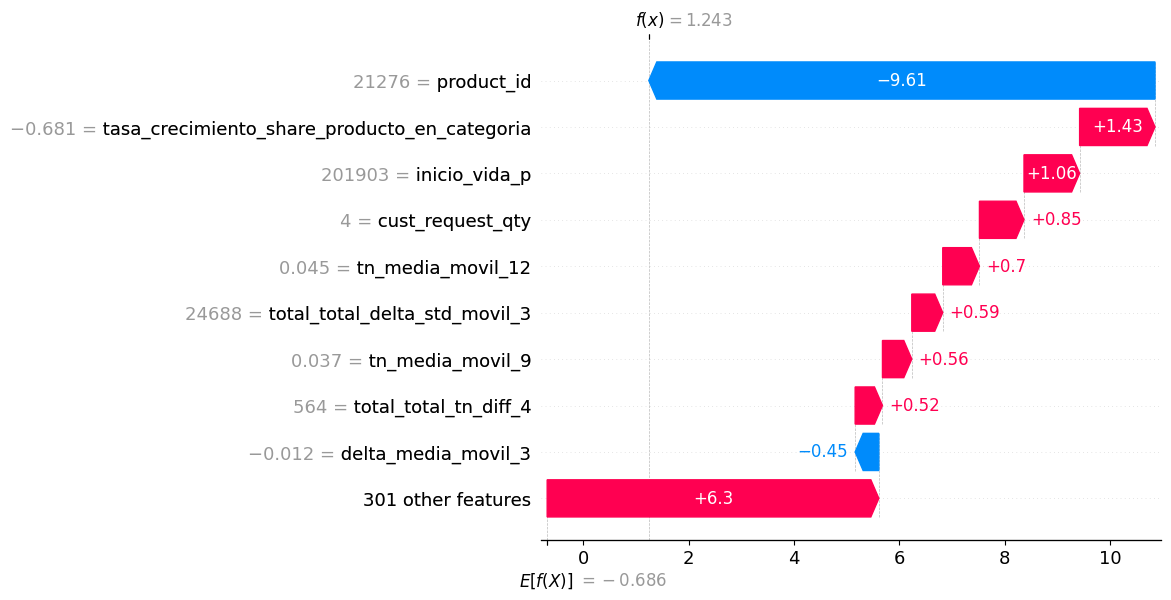

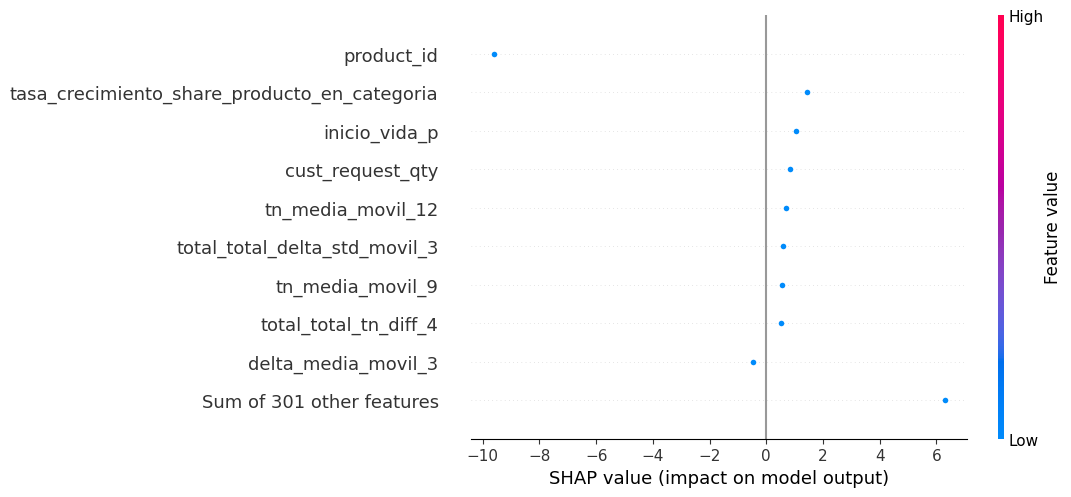

In [27]:
# Para una sola fila:
shap.plots.waterfall(shap_values[0])

# Para un resumen global de los productos chicos:
shap.plots.beeswarm(shap_values)

# armar prediccion

In [ ]:
# 2️⃣ cargá el preprocessor
import joblib
preprocessor, cols_to_scale, cols_to_keep, dtypes_originales, dtypes_escala = joblib.load(
    'escalador_completo_stddiv.joblib'
)

# 🔷 desescalar predicciones
pred_descaled = preprocessor.named_transformers_['custom_scaler'].inverse_transform(pred)

# 🔷 reconstruir como DataFrame
df_pred_descaled = pd.DataFrame(pred_descaled, columns=cols_to_scale)

# 🔷 opcional: restaurar dtypes (si querés)
for col in cols_to_scale:
    if pd.api.types.is_integer_dtype(dtypes_escala[col]):
        df_pred_descaled[col] = pd.to_numeric(df_pred_descaled[col], errors='coerce').astype(float)
    elif pd.api.types.is_float_dtype(dtypes_escala[col]):
        df_pred_descaled[col] = pd.to_numeric(df_pred_descaled[col], errors='coerce').astype(float)

# 🔷 opcional: si también tenés las columnas `cols_to_keep` las podés unir aquí
# por ejemplo si las guardaste en otro DataFrame llamado `df_metadata`:
# df_final = pd.concat([df_pred_descaled, df_metadata[cols_to_keep]], axis=1)

print(df_pred_descaled.head())


In [ ]:
df_pred_descaled["tn_predicha"]=df_pred_descaled["clase"]+df_pred_descaled["producto_total_tn"]
df_pred_descaled.loc[df_pred_descaled['tn_predicha'] < 0, 'tn_predicha'] = 0


In [ ]:
df_pred_descaled.rename(columns={"tn_predicha": "tn"}, inplace=True)

In [ ]:
df_pred_descaled[['product_id', 'tn']].to_csv('prediccion.csv', index=False)